# Lotka-Volterra Model

In [1]:
using AlgebraicPetri

using OrdinaryDiffEq
using Plots

using Catlab
using Catlab.Graphics
using Catlab.WiringDiagrams
using Catlab.CategoricalAlgebra
using Catlab.Programs.RelationalPrograms

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>".75"));

#### Step 1: Define the building block Petri nets needed to construct the model

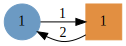

In [2]:
birth_petri = Open(PetriNet(1, 1=>(1,1)));
Graph(birth_petri)

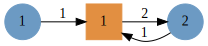

In [3]:
predation_petri = Open(PetriNet(2, (1,2)=>(2,2)));
Graph(predation_petri)

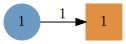

In [4]:
death_petri = Open(PetriNet(1, 1=>()));
Graph(death_petri)

#### Step 2: Generate models using a relational syntax

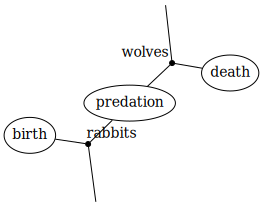

In [5]:
lotka_volterra = @relation (wolves, rabbits) begin
  birth(rabbits)
  predation(rabbits, wolves)
  death(wolves)
end
display_uwd(lotka_volterra)

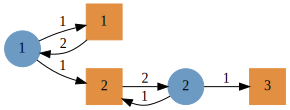

In [6]:
lv_dict = Dict(:birth=>birth_petri, :predation=>predation_petri, :death=>death_petri);
lotka_petri = apex(oapply(lotka_volterra, lv_dict))
Graph(lotka_petri)

Generate appropriate vector fields, define parameters, and visualize solution

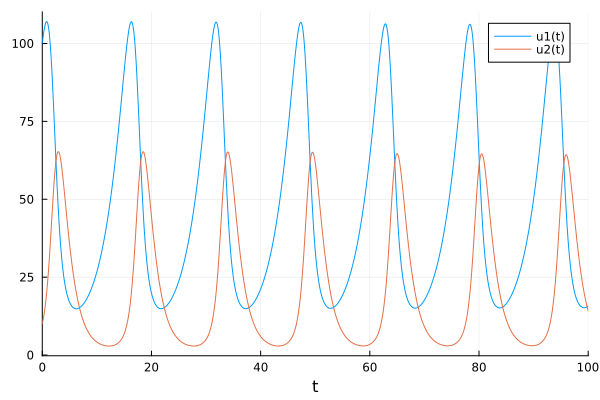

In [7]:
u0 = [100, 10];
p = [.3, .015, .7];
prob = ODEProblem(vectorfield(lotka_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5(),abstol=1e-8);
plot(sol)

#### Step 3: Extend your model to handle more complex phenomena
such as a small food chain between little fish, big fish, and sharks

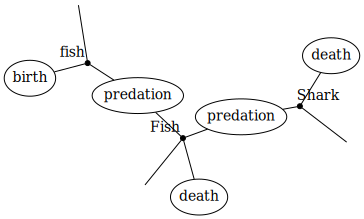

In [8]:
dual_lv = @relation (fish, Fish, Shark) begin
  birth(fish)
  predation(fish, Fish)
  death(Fish)
  predation(Fish, Shark)
  death(Shark)
end
display_uwd(dual_lv)

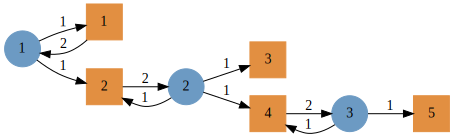

In [9]:
dual_lv_petri = apex(oapply(dual_lv, lv_dict))
Graph(dual_lv_petri)

Generate a new solver, provide parameters, and analyze results

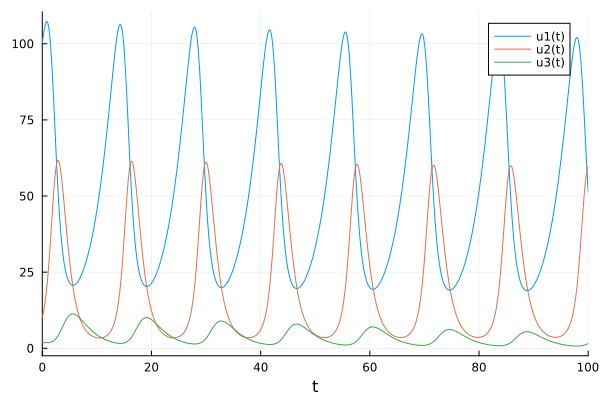

In [10]:
u0 = [100, 10, 2];
p = [.3, .015, .7, .017, .35];
prob = ODEProblem(vectorfield(dual_lv_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5(),abstol=1e-6);
plot(sol)